# Lab 1.3 Solution

## Section 1: Creating and Plotting Random Normal Data
This section will introduce you to creating and plotting random normal data using the numpy and math modules. The random normal data set will have a mean of 100, standard deviation of 25, and sample size of 1000.

In [1]:
# First, import the libraries you will need
import numpy as np
import matplotlib.pyplot as plt

#Also, add code to make sure your plots appear in your Jupyter notebook
%matplotlib inline 

In [2]:
# Create variables for the mean, standard deviation, and sample size of the data 
# as well as a variable for the number of bins used to plot the data as a 
# histogram later.
mean = 200
sd = 200
size = 1000
nbins = 10

# Create random data using the properties defined above and the np module.
data_normal = np.random.normal(mean, sd, size)

Now that the data has been created, plot the data as a histogram. Try changing the variables defined above, especially the number of bins and sample size, and seeing how the graph changes.

Text(0, 0.5, 'Number of Occurences')

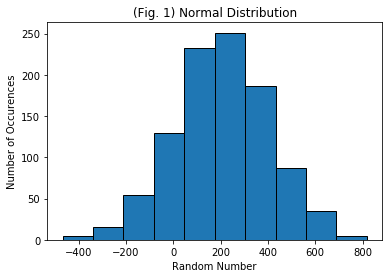

In [3]:
plt.figure()
plt.hist(data_normal, nbins, ec="black")
plt.title('(Fig. 1) Normal Distribution')
plt.xlabel('Random Number')
plt.ylabel('Number of Occurences')

## Section 2: Creating Random Lognormal Data
Next, generate and plot random lognormal data with the same mean, standard deviation, and sample size as above.  Refer back to Lecture 2 in class or to wikipedia's page on the lognormal distibution: https://en.wikipedia.org/wiki/Log-normal_distribution.  Note that the parameters $\mu$ and $\sigma$ in the lognormal distribution refer to the mean and the standard deviation of the variables natural logarithm, not of the original dataset.  If we use "mean" and "sd" to refer to what we would calculate for the original dataset, then we can calculate $\mu$ and $\sigma$ as follows:

First, the mean of $ln(RandomData)$ is ${\mu} = ln\bigg(\frac{mean^2}{\sqrt{mean^2 + sd^2}}\bigg)$
and the standard deviation is ${\sigma} = \sqrt{ln\bigg(\frac{mean^2 + sd^2}{mean^2}\bigg)}$.

In [4]:
mean = 100
sd = 25
size = 1000
nbins = 20

# Find the mean and standard deviation for ln(RandomData)
mu = np.log(mean**2 / np.sqrt(mean**2 + sd**2))
sigma = np.sqrt(np.log((mean**2 + sd**2) / (mean**2)))

# Create random data 
data_lognormal = np.random.lognormal(mu, sigma, size)

Now plot the data. Try changing the variables above to see how the graph changes.

Text(0, 0.5, 'Number of Occurences')

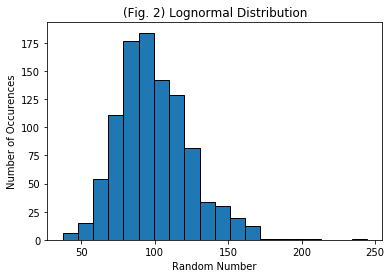

In [5]:
plt.figure()
plt.hist(data_lognormal, nbins, ec="black")
plt.title('(Fig. 2) Lognormal Distribution')
plt.xlabel('Random Number')
plt.ylabel('Number of Occurences')

## Section 3: Creating Random Uniform Data
Next, generate random uniform data with the same mean, standard deviation, and sample size as above.  Consider Lecture 2 on the uniform distribution or see wikipedia:  https://en.wikipedia.org/wiki/Uniform_distribution_(continuous) 

First, for ${f(x)} = \frac{1}{b-a}$, the mean is ${\mu} = \frac{b+a}{2}$
and the standard deviation is ${\sigma} = \frac{b-a}{\sqrt{12}}$.

So, ${a} = \mu-\sigma\sqrt{3}$ and ${b} = \mu+\sigma\sqrt{3}$.

In [6]:
mean = 100
sd = 50
size = 1000
nbins = 10

# Find the bounds for uniform data
a = mean - sd*np.sqrt(3)
b = mean + sd*np.sqrt(3)

# Create random data 
data_uniform = np.random.uniform(a, b, size)

Now plot the data. Try changing the variables above to see how the graph changes.

Text(0, 0.5, 'Number of Occurences')

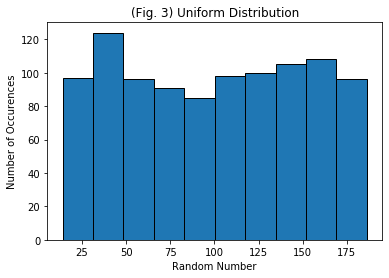

In [7]:
plt.figure(3)
plt.hist(data_uniform, nbins, ec="black")
plt.title('(Fig. 3) Uniform Distribution')
plt.xlabel('Random Number')
plt.ylabel('Number of Occurences')

---

# Fun with fake data!

One of the most reliable tests of any statistical method or technique is to try it out on data where you know the answer. This lets you see if the methodology gives you the result you expect. The best way to get data that truly understand is to make it up yourself.

Try the following activity:
- Create data with known distributions, all with the same **mean = 60**, and **standard deviation = 40**
  - Generate **1000** random numbers with a normal distribution with `np.random.normal()`
  - Generate **1000** random numbers with a log-normal distribution with `np.random.lognormal()`
  - Generate **1000** random numbers with a uniform distribution with `np.random.uniform()` (You’ll need to think about what the interval should be for this uniform distribution.)
- For each set of random numbers, make the following plots:
  - histogram
  - boxplot
  - quantile plots
  - PDFs
- Compare the plots, and discuss how you can tell the distributions apart.

Now repeat the above steps, but generate **100** random numbers for each set, then **25** numbers, then **10** numbers.
- For each of these, can you tell the distributions apart? 
- What is the sample mean and standard deviation for each?
- Discuss the difference between a sample population and the true population.

### **Solution:**


In [8]:
import scipy.stats as stats

All of my fake data should have the same mean and standard deviation, so I'll define those here first:

In [9]:
my_mean = 60
my_standard_deviation = 40

In [10]:
# I want 1000 random numbers from each
size = 1000

#### Normal Distribution
Next, I want to generate 1000 random numbers from a **normal distribution** with the mean and standard deviation from above.

In [11]:
# Generate random numbers from a normal distribution
normal_numbers = np.random.normal(my_mean, my_standard_deviation, size)

Check that we got the mean and standard deviation that we wanted:

In [12]:
print('Mean = {}'.format(normal_numbers.mean()))
print('Standard Deviation = {}'.format(normal_numbers.std()))

Mean = 60.740298011737075
Standard Deviation = 40.497583345772135


Make our plots:

Text(0.5, 1.0, 'PDF')

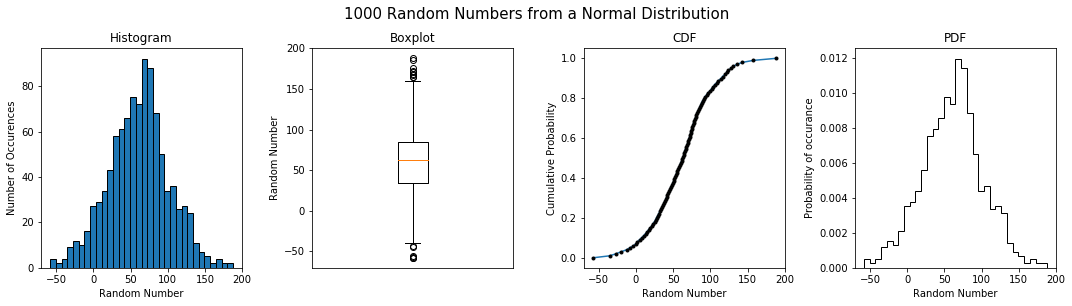

In [13]:
# Set up a plot figure, with one row of four subplots, and I've given each subplot axes object a name
fig, [hist_ax, box_ax, cdf_ax, pdf_ax] = plt.subplots(nrows=1, ncols=4, figsize=(15,4), tight_layout=True)

fig.suptitle('{n} Random Numbers from a Normal Distribution'.format(n=size), x=.5, y=1.05, fontsize='15')

# Make a histogram plot
hist_ax.hist(normal_numbers, bins='sqrt', edgecolor='k') # using the square root method to determine number of bins
hist_ax.set_xlabel('Random Number')
hist_ax.set_ylabel('Number of Occurences')
hist_ax.set_title('Histogram')

# Make a boxplot
box_ax.boxplot(normal_numbers) # using the square root method to determine number of bins
box_ax.get_xaxis().set_visible(False) # hide the x-axis
box_ax.set_ylabel('Random Number')
box_ax.set_title('Boxplot')

# Compute quantiles for the CDF plot
prob = np.linspace(0,1,100) # calculate probabilities for 100 values 0-1
quantiles = stats.mstats.mquantiles(normal_numbers, prob=prob, alphap=0.4, betap=0.4) # values for alphap and betap here give us the Cunnane plotting position
# Make a CDF plot
cdf_ax.plot(quantiles, prob, '.-', markerfacecolor='k', markeredgecolor='k')
cdf_ax.set_xlabel('Random Number')
cdf_ax.set_ylabel('Cumulative Probability')
cdf_ax.set_title('CDF')

# Make a PDF plot
pdf_ax.hist(normal_numbers, bins='sqrt', edgecolor='k', density=True, histtype='step') # using density=True to normalize, and the square root method to determine number of bins
pdf_ax.set_xlabel('Random Number')
pdf_ax.set_ylabel('Probability of occurance')
pdf_ax.set_title('PDF')

#### Log-normal Distribution
For generating random numbers from a **log-normal distribution**, take a look at the documentation for the [np.normal.lognormal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.lognormal.html) function. This specifies that the mean and standard deviation we give the function are the mean and standard deviation of the **underlying normal distribution**, not of the lognormal distribution itself. [See Wikipedia for details!](https://en.wikipedia.org/wiki/Log-normal_distribution#Generation_and_parameters)

This means we have to log-tranform our target mean (60) and standard deviation (40) before running the lognormal function.

$\mu_{log} = \log\left(\frac{\mu_X^2}{\sqrt{\mu_X^2+\sigma_X^2}}\right)$

$\sigma_{log} = \sqrt{ \log\left(1+\frac{\sigma_X^2}{\mu_X^2}\right) }$ 

Where in the equations above $\mu$ and $\sigma$ are our target mean and standard deviation, and $\mu_{log}$ and $\sigma_{log}$ are the log-transformed mean and standard deviation.


In [14]:
# Find the mean and standard deviation for ln(RandomData)
my_mean_log = np.log(my_mean**2 / np.sqrt(my_mean**2 + my_standard_deviation**2))
my_standard_deviation_log = np.sqrt(np.log((my_mean**2 + my_standard_deviation**2) / (my_mean**2)))

# Generate random numbers from a lognormal distribution
lognormal_numbers = np.random.lognormal(my_mean_log, my_standard_deviation_log, size)

Check that we got the mean and standard deviation that we wanted:

In [15]:
print('Mean = {}'.format(lognormal_numbers.mean()))
print('Standard Deviation = {}'.format(lognormal_numbers.std()))

Mean = 61.54945448703395
Standard Deviation = 42.55616105253805


Make our plots:

Text(0.5, 1.0, 'PDF')

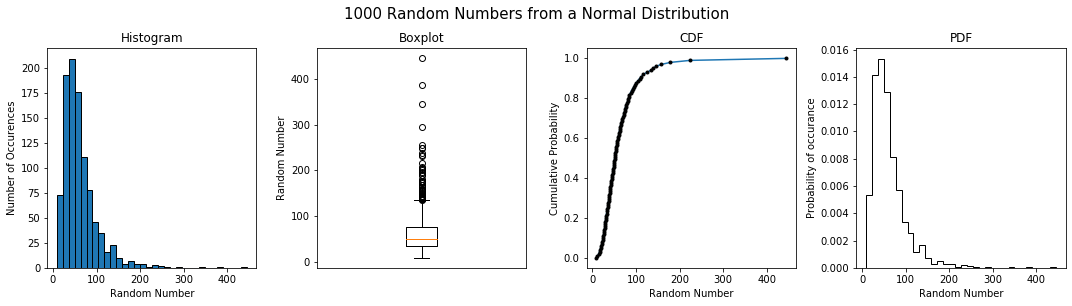

In [16]:
# Set up a plot figure, with one row of four subplots, and I've given each subplot axes object a name
fig, [hist_ax, box_ax, cdf_ax, pdf_ax] = plt.subplots(nrows=1, ncols=4, figsize=(15,4), tight_layout=True)

fig.suptitle('{n} Random Numbers from a Normal Distribution'.format(n=size), x=.5, y=1.05, fontsize='15')
             
# Make a histogram plot
hist_ax.hist(lognormal_numbers, bins='sqrt', edgecolor='k') # using the square root method to determine number of bins
hist_ax.set_xlabel('Random Number')
hist_ax.set_ylabel('Number of Occurences')
hist_ax.set_title('Histogram')

# Make a boxplot
box_ax.boxplot(lognormal_numbers) # using the square root method to determine number of bins
box_ax.get_xaxis().set_visible(False) # hide the x-axis
box_ax.set_ylabel('Random Number')
box_ax.set_title('Boxplot')

# Compute quantiles for the CDF plot
prob = np.linspace(0,1,100) # calculate probabilities for 100 values 0-1
quantiles = stats.mstats.mquantiles(lognormal_numbers, prob=prob, alphap=0.4, betap=0.4) # values for alphap and betap here give us the Cunnane plotting position
# Make a CDF plot
cdf_ax.plot(quantiles, prob, '.-', markerfacecolor='k', markeredgecolor='k')
cdf_ax.set_xlabel('Random Number')
cdf_ax.set_ylabel('Cumulative Probability')
cdf_ax.set_title('CDF')

# Make a PDF plot
pdf_ax.hist(lognormal_numbers, bins='sqrt', edgecolor='k', density=True, histtype='step') # using density=True to normalize, and the square root method to determine number of bins
pdf_ax.set_xlabel('Random Number')
pdf_ax.set_ylabel('Probability of occurance')
pdf_ax.set_title('PDF')

#### Uniform Distribution
For the **uniform distribution**, note that instead of specifying a mean and standard deviation, the [np.random.uniform()](https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html) function requires *low* and *high* interval values. But what should these values be?

From [the equations the describe the mean and variance for a uniform distribution](https://www.itl.nist.gov/div898/handbook/eda/section3/eda3662.htm) on $[A,B]$, we can drive the following equations to solve for $A$ and $B$ given a target mean and standard deviation.


$A = \bar{X} - s\sqrt{3}$

$B = \bar{X} + s\sqrt{3}$

(Bookmark this website or download a copy of the [pdf](https://www.itl.nist.gov/div898/handbook/toolaids/pff/E-Handbook.pdf) of the [Engineering Statistics Handbook](https://www.itl.nist.gov/div898/handbook/index.htm) from the National Institute of Standards and Technology.)



In [17]:
# Find the upper and lower bounds that will give me the mean and standard deviation that I want
a = my_mean - my_standard_deviation*np.sqrt(3)
b = my_mean + my_standard_deviation*np.sqrt(3)

# Generate random numbers from a uniform distribution
uniform_numbers = np.random.uniform(a, b, size)

Check that we got the mean and standard deviation that we wanted:

In [18]:
print('Mean = {}'.format(uniform_numbers.mean()))
print('Standard Deviation = {}'.format(uniform_numbers.std()))

Mean = 59.567622903860794
Standard Deviation = 39.98965611047311


Make our plots:

Text(0.5, 1.0, 'PDF')

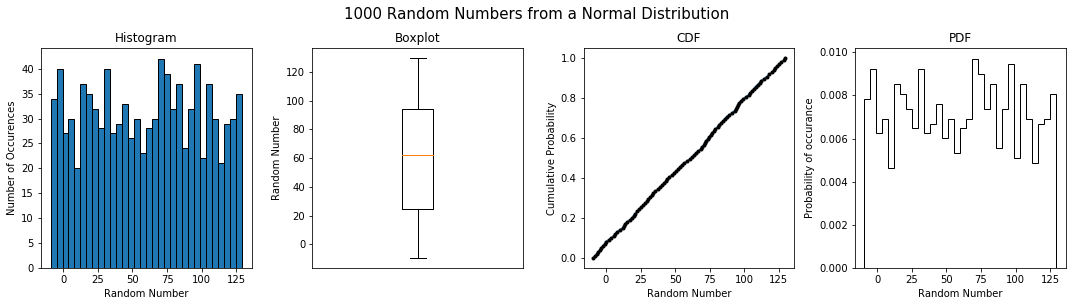

In [19]:
# Set up a plot figure, with one row of four subplots, and I've given each subplot axes object a name
fig, [hist_ax, box_ax, cdf_ax, pdf_ax] = plt.subplots(nrows=1, ncols=4, figsize=(15,4), tight_layout=True)

fig.suptitle('{n} Random Numbers from a Normal Distribution'.format(n=size), x=.5, y=1.05, fontsize='15')
             
# Make a histogram plot
hist_ax.hist(uniform_numbers, bins='sqrt', edgecolor='k') # using the square root method to determine number of bins
hist_ax.set_xlabel('Random Number')
hist_ax.set_ylabel('Number of Occurences')
hist_ax.set_title('Histogram')

# Make a boxplot
box_ax.boxplot(uniform_numbers) # using the square root method to determine number of bins
box_ax.get_xaxis().set_visible(False) # hide the x-axis
box_ax.set_ylabel('Random Number')
box_ax.set_title('Boxplot')

# Compute quantiles for the CDF plot
prob = np.linspace(0,1,100) # calculate probabilities for 100 values 0-1
quantiles = stats.mstats.mquantiles(uniform_numbers, prob=prob, alphap=0.4, betap=0.4) # values for alphap and betap here give us the Cunnane plotting position
# Make a CDF plot
cdf_ax.plot(quantiles, prob, '.-', markerfacecolor='k', markeredgecolor='k')
cdf_ax.set_xlabel('Random Number')
cdf_ax.set_ylabel('Cumulative Probability')
cdf_ax.set_title('CDF')

# Make a PDF plot
pdf_ax.hist(uniform_numbers, bins='sqrt', edgecolor='k', density=True, histtype='step') # using density=True to normalize, and the square root method to determine number of bins
pdf_ax.set_xlabel('Random Number')
pdf_ax.set_ylabel('Probability of occurance')
pdf_ax.set_title('PDF')